In [1]:
# Libraries
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

from sklearn.metrics         import mean_squared_error
from sklearn.tree            import DecisionTreeRegressor
from sklearn.preprocessing   import StandardScaler
from sklearn.utils           import resample
from sklearn.ensemble        import AdaBoostRegressor

In [2]:
# local file paths

dir_name = 'selezione'
region_names = np.array(['A', 'B', 'C'])

fp_Xtrain = []
fp_Xval   = []
fp_Xtest  = []
fp_ytrain = []
fp_yval   = []
fp_ytest  = []

for i in range(3):
    fp_Xtrain.append(dir_name + f'/X_train{region_names[i]}.csv')
    fp_Xval  .append(dir_name + f'/X_val{  region_names[i]}.csv')
    fp_Xtest .append(dir_name + f'/X_test{ region_names[i]}.csv')
    fp_ytrain.append(dir_name + f'/y_train{region_names[i]}.csv')
    fp_yval  .append(dir_name + f'/y_val{  region_names[i]}.csv')
    fp_ytest .append(dir_name + f'/y_test{ region_names[i]}.csv')

In [3]:
# Lettura dei dati

X_train = []
X_val   = []
X_test  = []
y_train = []
y_val   = []
y_test  = []

for i in range(3):
    X_train.append(pd.read_csv(fp_Xtrain[i], low_memory=False))
    X_val  .append(pd.read_csv(fp_Xval  [i], low_memory=False))        
    X_test .append(pd.read_csv(fp_Xtest [i], low_memory=False))
    y_train.append(pd.read_csv(fp_ytrain[i], low_memory=False))
    y_val  .append(pd.read_csv(fp_yval  [i], low_memory=False))        
    y_test .append(pd.read_csv(fp_ytest [i], low_memory=False))
    
X_train = np.array(X_train, dtype=object)
X_val   = np.array(X_val,   dtype=object)
X_test  = np.array(X_test,  dtype=object)
y_train = np.array(y_train, dtype=object)
y_val   = np.array(y_val,   dtype=object)
y_test  = np.array(y_test,  dtype=object)

In [4]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
            print()

In [5]:
dimensionality(y=True)

X_trainA: (26819, 60)
X_valA:   (9006, 60)
X_testA:  (9085, 60)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 52)
X_valB:   (2658, 52)
X_testB:  (2606, 52)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 36)
X_valC:   (21908, 36)
X_testC:  (21876, 36)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



# Costruzione DecisionTreeRegressor #

In [6]:
plt.rcParams.update({'font.size': 35})

In [7]:
def get_bias_var_mse(X, y, model):
        y_pred = model.predict(X)
        return {
            'bias': ((y - np.mean(y_pred))**2).mean(),\
            'var':  np.var(y_pred).mean(),\
            'mse':  ((y_pred - y.reshape(-1,1))**2).mean()
        }

In [8]:
# Costruzione Decision TreeRegressor
def DecisionTreeRegressor_validation(X_train, y_train, X_val, y_val, verbose=False, debug=False):
    
    def get_dec_tree_reg(max_leaf):
        dt = DecisionTreeRegressor(max_leaf_nodes=max_leaf)
        dt.fit(X_train,y_train)
        return dt
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'TUNING DEL MASSIMO NUMERO DI FOGLIE {name}')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = np.argmin(stats[n]) + start
            
            print (f'Punteggio finale: {stats[n][-1]} ({end}) stimatori')
            print (f'Best {n}: {min_}')
            print (f'Best number of Estimators: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(start, end+1),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(start, end+1),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(start, end+1),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f"{name} MSE, BIAS, VARIANCE on differe Estimators", fontsize=15)
        ax.set_xlabel("Number of Max Estimators used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()

    start =   2
    end   =  100
    
    model_start = get_dec_tree_reg(start)
    
    _, _, best_mse = bias_var_mse(X_train, y_train, model_start)
    
    best_max_leaf = start
    best_model      = model_start
    
    info         = []
    
    train_stats  = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    val_stats    = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    } 
    
    for max_leaf in range(start, end+1):
        
        if debug:
            print(f'{max_leaf}/{end}')
    
        model = get_dec_tree_reg(max_leaf)
        
        trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, model)
        val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, model)

        train_stats['bias'].append(trn_bias)
        train_stats['var' ].append(trn_var )
        train_stats['mse' ].append(trn_mse )
        
        val_stats['bias'].append(val_bias)
        val_stats['var' ].append(val_var )
        val_stats['mse' ].append(val_mse )
        
        info.append(f'Max Leaf: {max_leaf}' +\
                    f'\n(Train MSE:       {trn_mse }  - Val MSE:      {val_mse })' +\
                    f'\n(Train Bias:      {trn_bias}  - Val Bias:     {val_bias})' +\
                    f'\n(Train Variance:  {trn_var }  - Val Variance: {val_var })' )

        if(val_mse < best_mse):
            best_mse = val_mse
            best_max_leaf = max_leaf
            best_model = model
    
    if verbose:
        print()
        print("MSE, BIAS, VARIANCE Train e Validation")
        print(*info, sep='\n')
        print()
        
    plot_mse(train_stats, "TRAIN"     )
    plot_mse(  val_stats, "VALIDATION")
                
    return best_model

In [9]:
dt_model = []

In [10]:
def get_dt(index, verbose=False, debug=False):
    return DecisionTreeRegressor_validation(
        X_train[index],\
        y_train[index],\
        X_val  [index],\
        y_val  [index],\
        verbose = verbose,\
        debug   = debug,\
    )

TUNING DEL MASSIMO NUMERO DI FOGLIE TRAIN

Punteggio finale: 0.007711566129502256 (100) stimatori
Best mse: 0.006960894645976323
Best number of Estimators: 2

Punteggio finale: 0.006929363357698049 (100) stimatori
Best bias: 0.006929363357698049
Best number of Estimators: 2

Punteggio finale: 0.0007822027718040815 (100) stimatori
Best var: 3.153128827826026e-05
Best number of Estimators: 2

TUNING DEL MASSIMO NUMERO DI FOGLIE VALIDATION

Punteggio finale: 0.028223805756449227 (100) stimatori
Best mse: 0.0272985675482187
Best number of Estimators: 2

Punteggio finale: 0.027267389691690923 (100) stimatori
Best bias: 0.027266047528320802
Best number of Estimators: 86

Punteggio finale: 0.0009564160647582635 (100) stimatori
Best var: 3.1731774035200205e-05
Best number of Estimators: 2



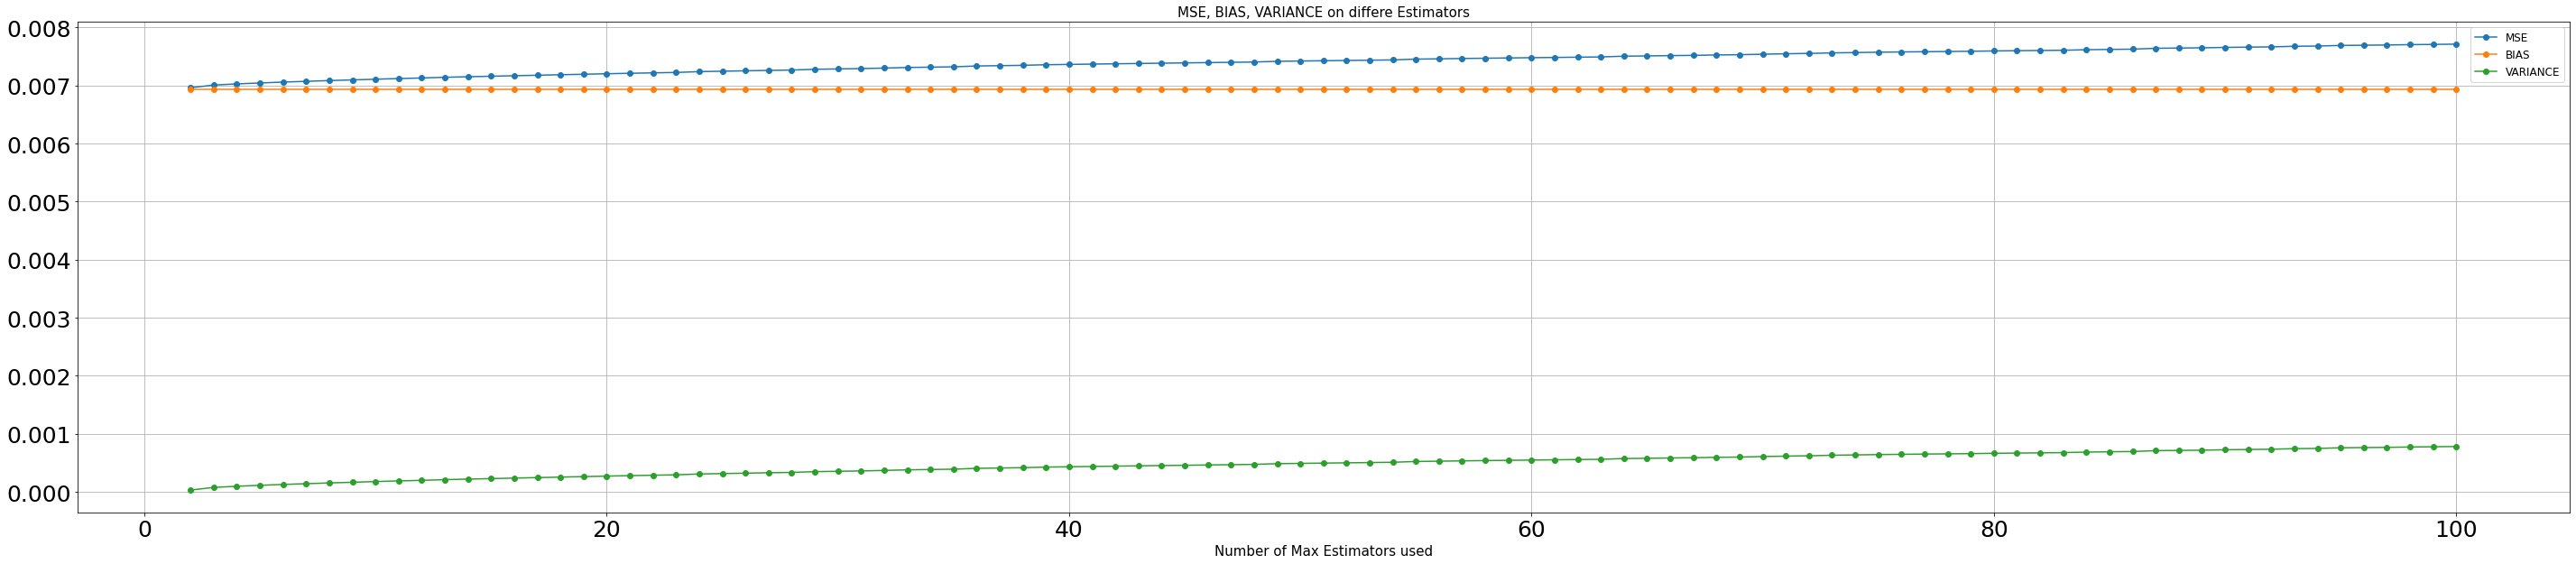

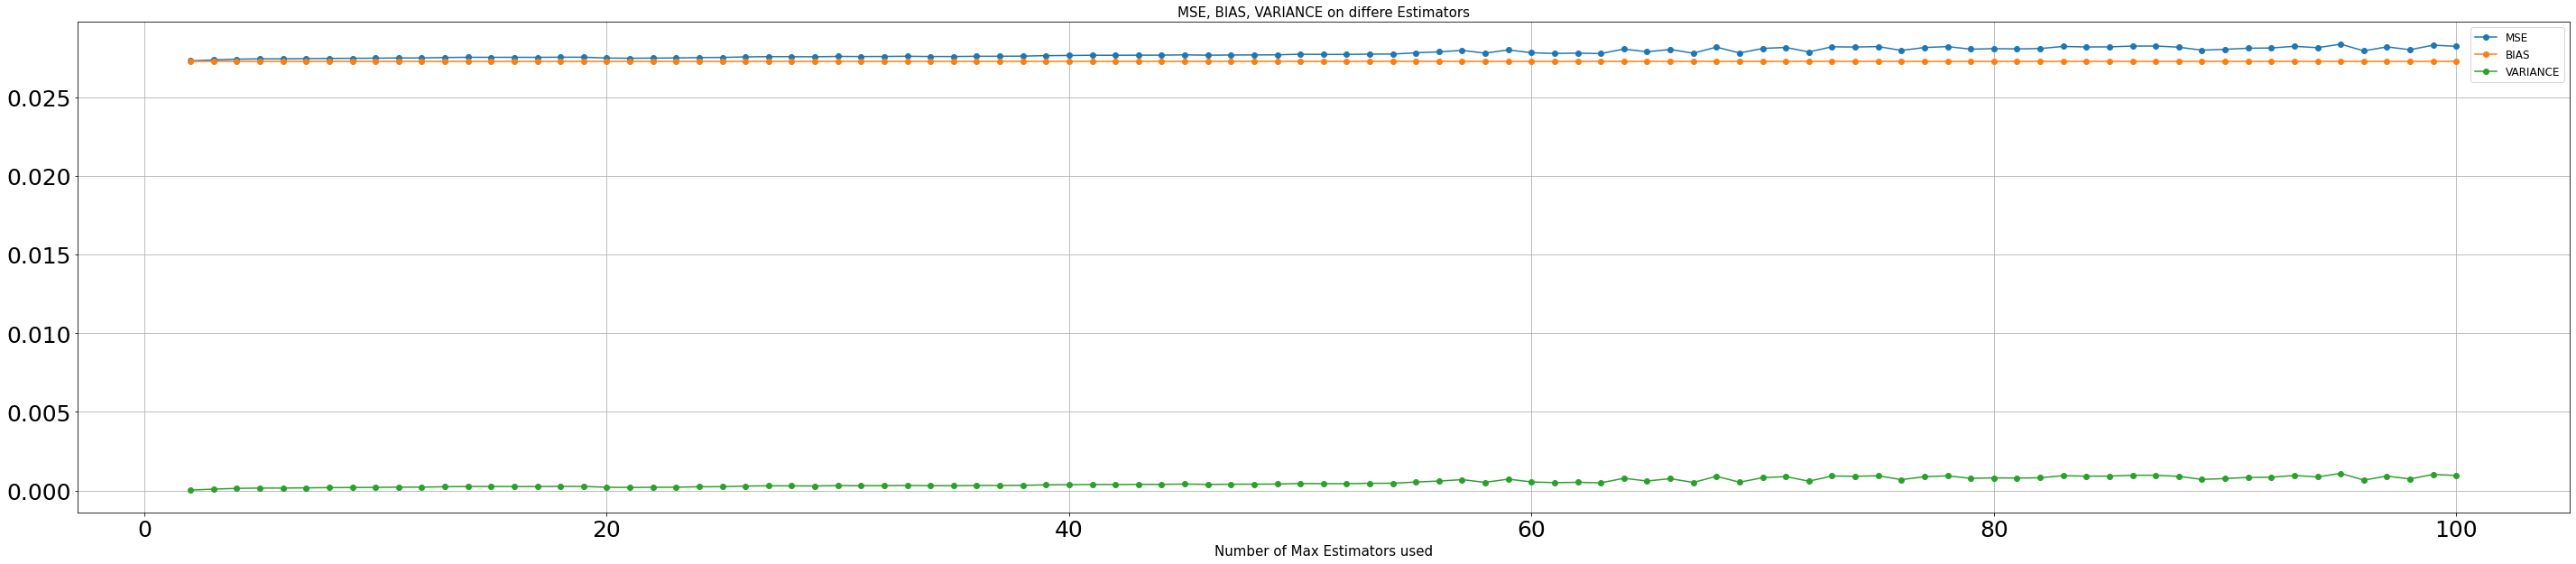

In [11]:
dt_model.append(
    get_dt(0)
)

TUNING DEL MASSIMO NUMERO DI FOGLIE TRAIN

Punteggio finale: 0.009455837507425431 (100) stimatori
Best mse: 0.007589006130014988
Best number of Estimators: 2

Punteggio finale: 0.007534069940127181 (100) stimatori
Best bias: 0.00753406994012718
Best number of Estimators: 5

Punteggio finale: 0.0019217675672982598 (100) stimatori
Best var: 5.493618988780845e-05
Best number of Estimators: 2

TUNING DEL MASSIMO NUMERO DI FOGLIE VALIDATION

Punteggio finale: 0.021856547710274773 (100) stimatori
Best mse: 0.01965077416036439
Best number of Estimators: 3

Punteggio finale: 0.019604020906318718 (100) stimatori
Best bias: 0.019598261809504344
Best number of Estimators: 88

Punteggio finale: 0.0022525268039560726 (100) stimatori
Best var: 4.769583558936017e-05
Best number of Estimators: 3



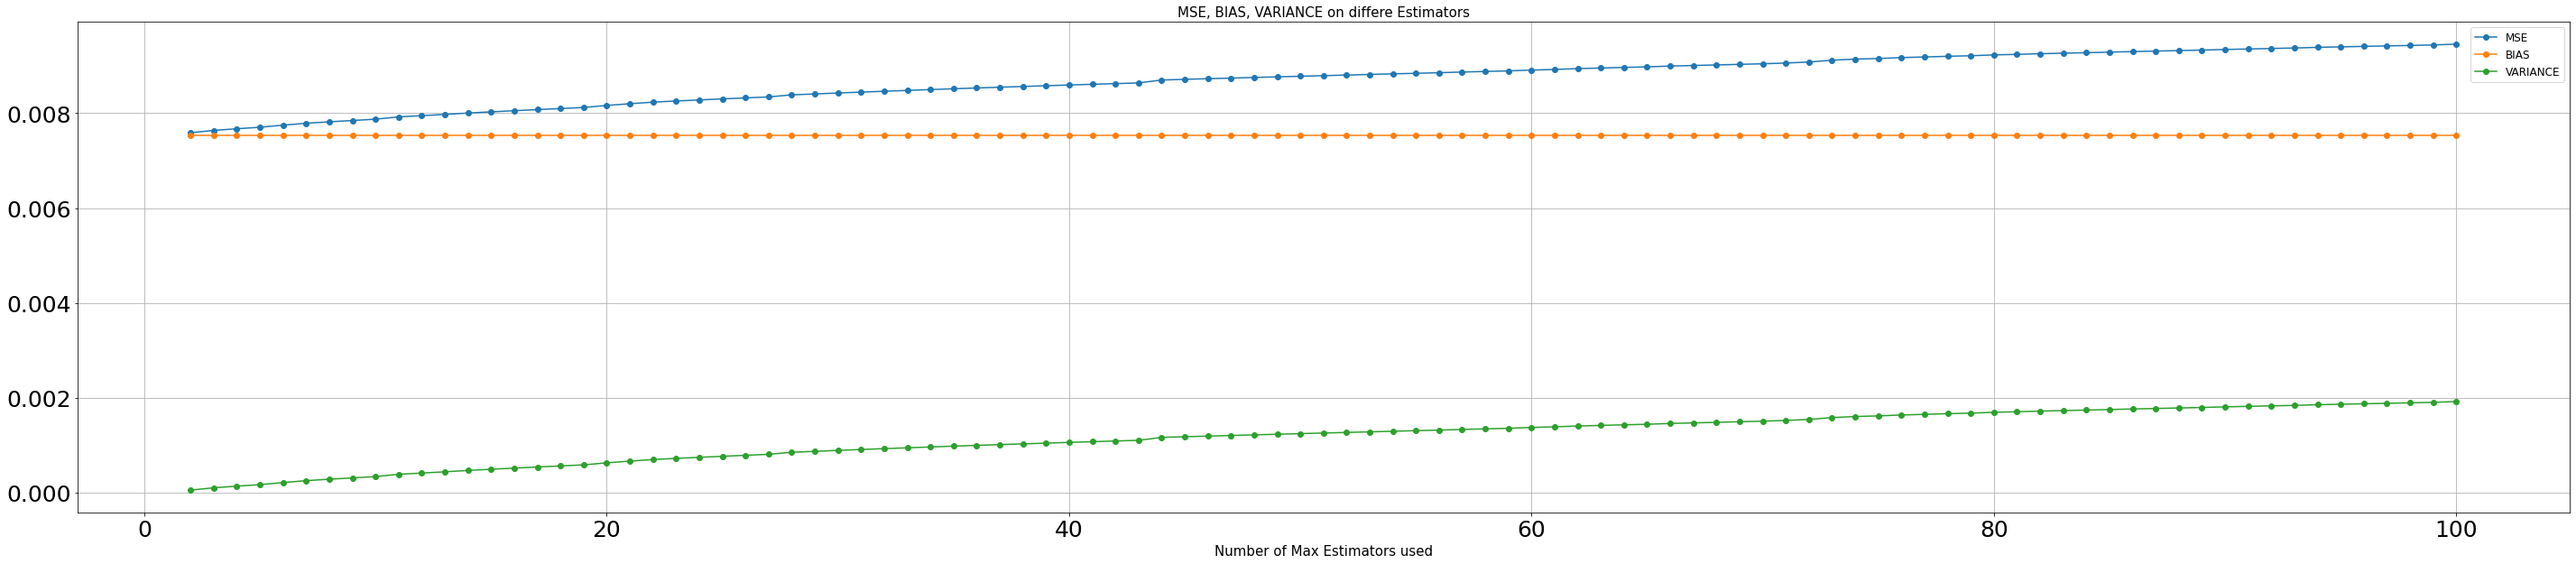

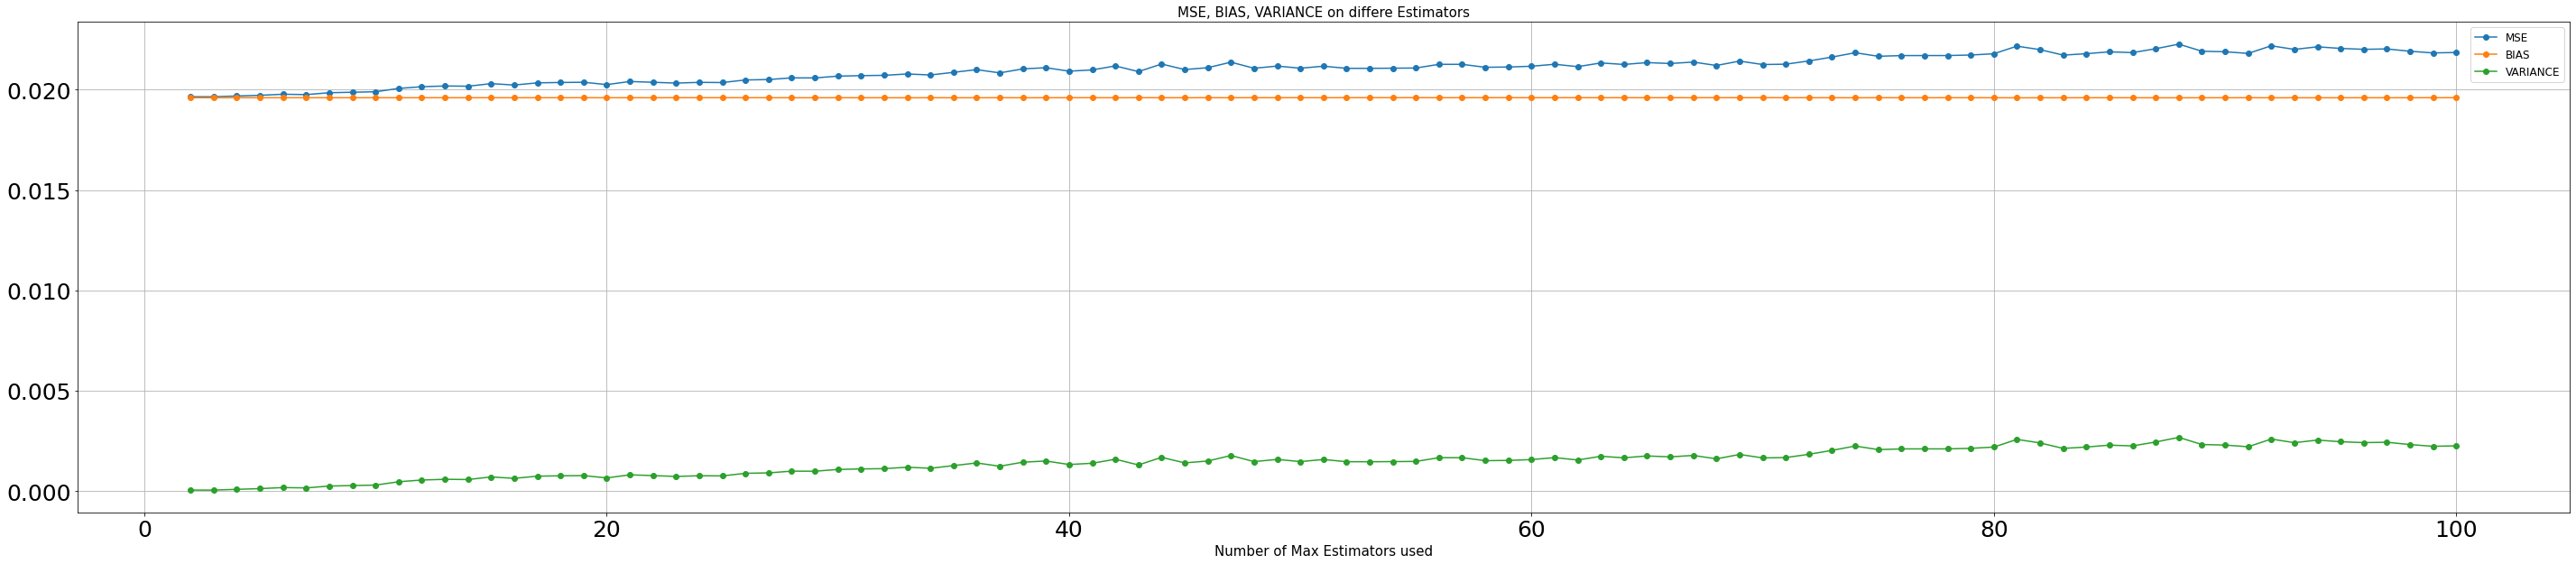

In [12]:
dt_model.append(
    get_dt(1)
)

TUNING DEL MASSIMO NUMERO DI FOGLIE TRAIN

Punteggio finale: 0.012155964661589903 (100) stimatori
Best mse: 0.011314432284468419
Best number of Estimators: 2

Punteggio finale: 0.011265328727628292 (100) stimatori
Best bias: 0.011265328727628292
Best number of Estimators: 2

Punteggio finale: 0.0008906359339611662 (100) stimatori
Best var: 4.910355684026944e-05
Best number of Estimators: 2

TUNING DEL MASSIMO NUMERO DI FOGLIE VALIDATION

Punteggio finale: 0.025970802011786906 (100) stimatori
Best mse: 0.024983408970021666
Best number of Estimators: 3

Punteggio finale: 0.024934954975215497 (100) stimatori
Best bias: 0.024934738966211133
Best number of Estimators: 76

Punteggio finale: 0.001035847036571474 (100) stimatori
Best var: 4.8433633551660965e-05
Best number of Estimators: 3



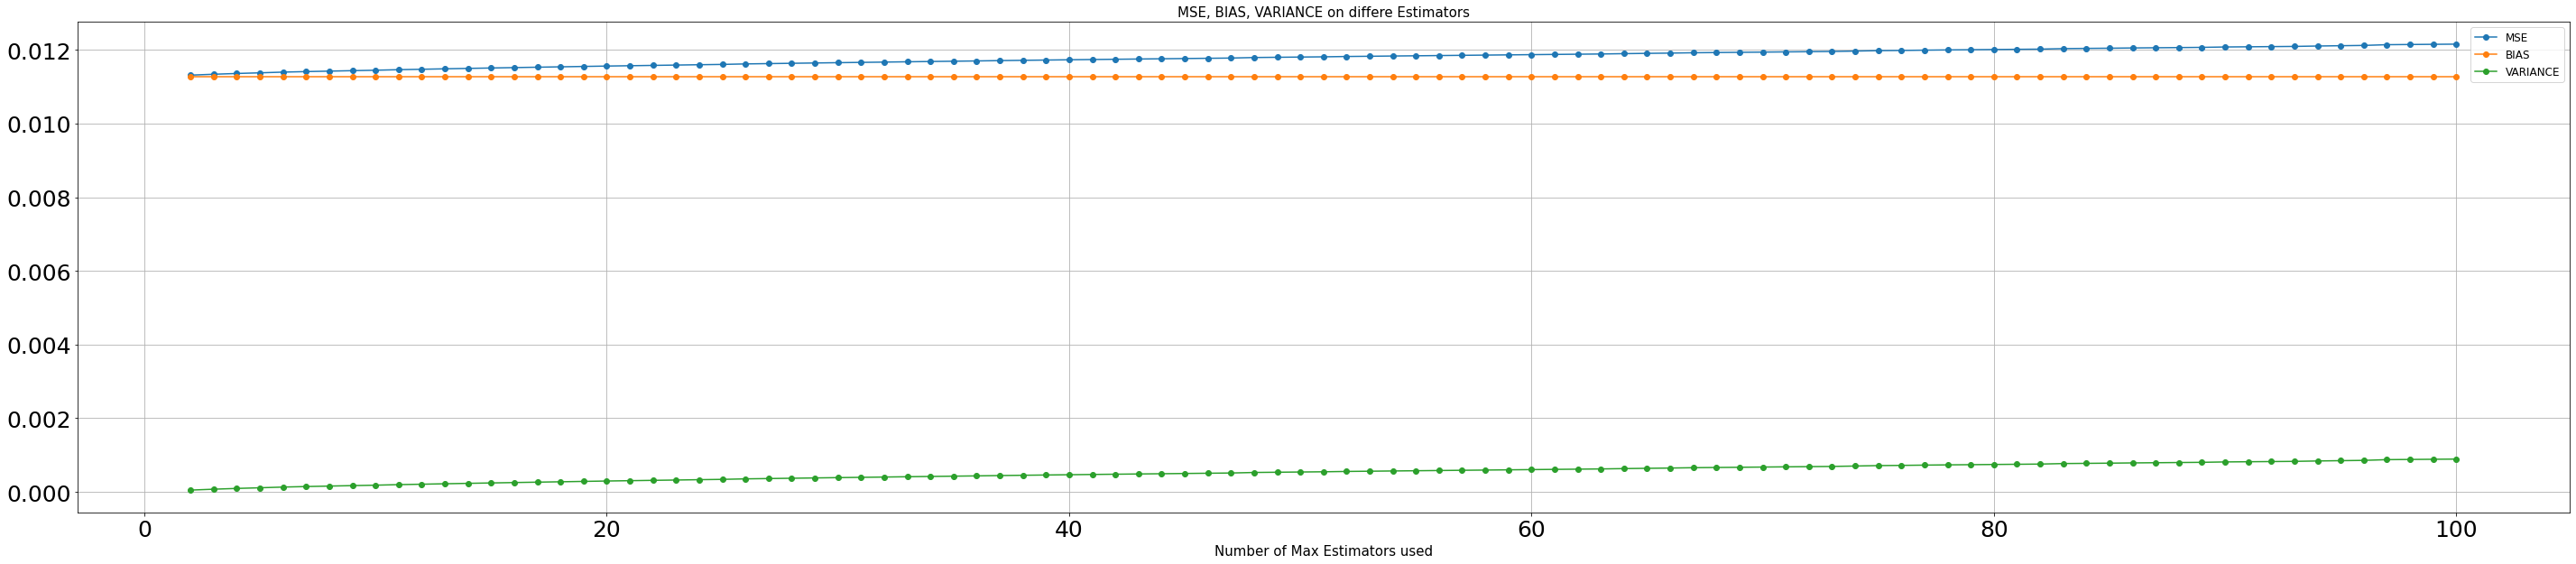

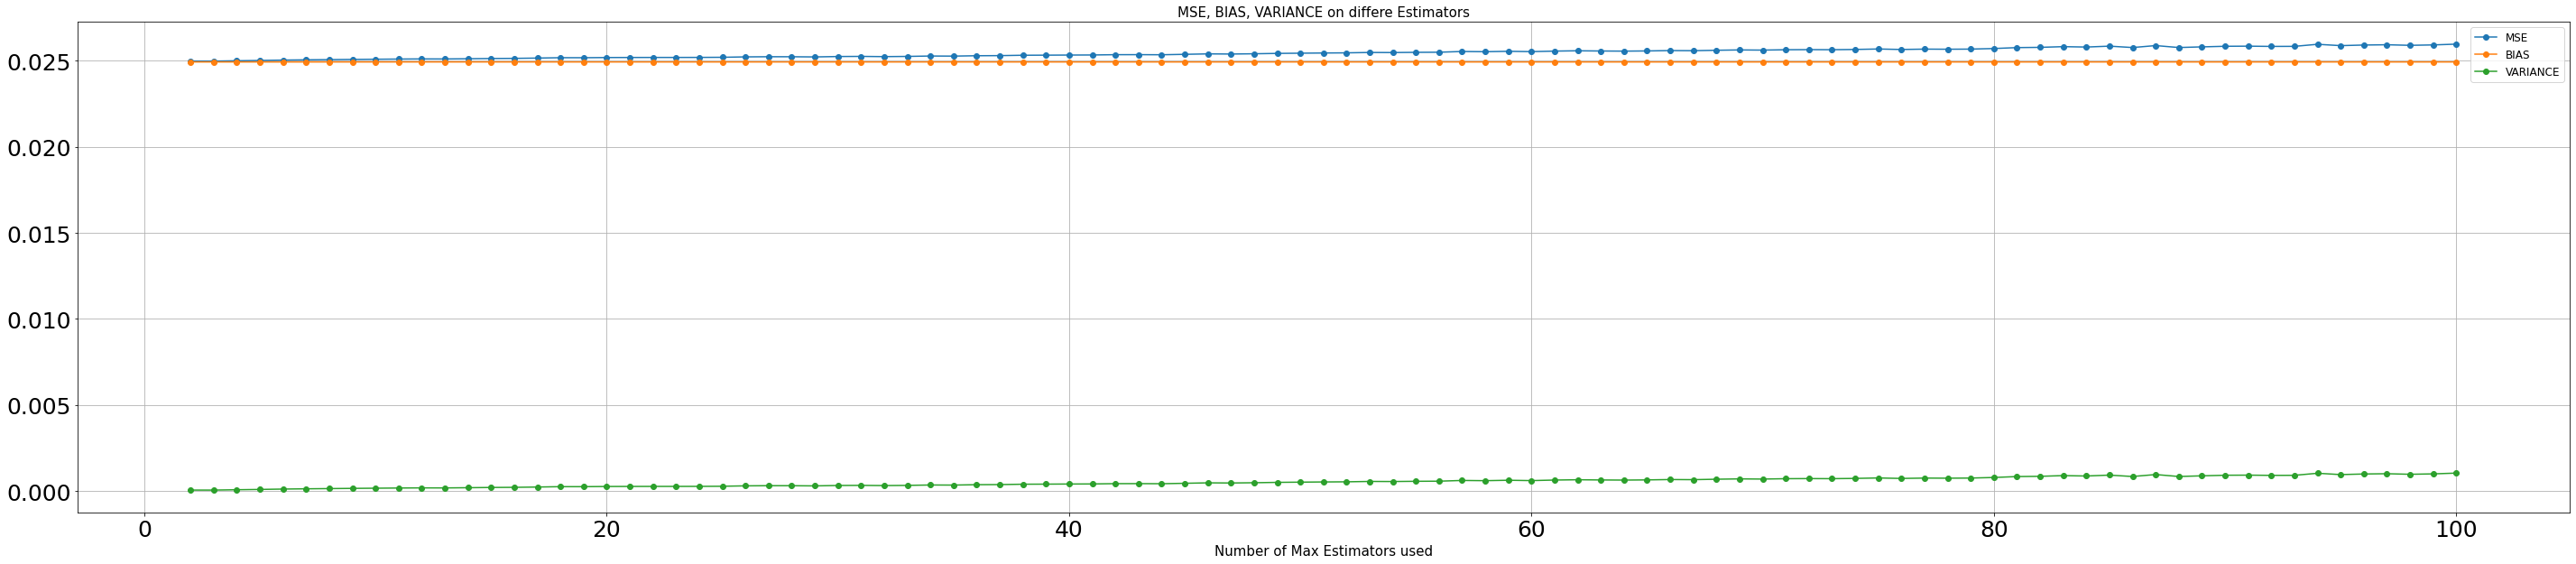

In [13]:
dt_model.append(
    #get_dt(2)
    DecisionTreeRegressor_validation(
        X_train[2][:30000],\
        y_train[2][:30000],\
        X_val  [2],\
        y_val  [2],\
        verbose = False,\
        debug   = False,\
    )
)

In [14]:
def get_score(model, X, y):
    return {
        'mse'  : mean_squared_error(y_true=y,   y_pred=model.predict(X)),
        'score': model.score(X, y)
    }

In [15]:
# Train
for i in range(3):
    print(region_names[i])
    print(get_score(dt_model[i], X_train[i], y_train[i]))
    print()

A
{'mse': 0.006897832069419788, 'score': 0.004550387481590534}

B
{'mse': 0.007479133750239372, 'score': 0.007291701606752299}

C
{'mse': 0.011166398675037253, 'score': 0.0037460585432452786}



In [16]:
# Validation
for i in range(3):
    print(region_names[i])
    print(get_score(dt_model[i], X_val[i], y_val[i]))
    print()

A
{'mse': 0.027262443078931616, 'score': 8.48505213923989e-05}

B
{'mse': 0.01964615446129854, 'score': -0.002603484000547329}

C
{'mse': 0.02490576162768586, 'score': 0.0011582961438302286}



In [17]:
# Test
for i in range(3):
    print(region_names[i])
    print(get_score(dt_model[i], X_test[i], y_test[i]))
    print()

A
{'mse': 0.028613882269118193, 'score': 7.476244924164988e-05}

B
{'mse': 0.024081381834904592, 'score': -0.0005303210091422983}

C
{'mse': 0.029117092511553727, 'score': 0.0010186128711099363}



Da dove proviene l'errore?

In [18]:
for i in range(2): #range(3)
    print(region_names[i])
    print('Train     ', get_bias_var_mse(X_train[i], y_train[i].values.ravel(), dt_model[i]))
    print('Validation', get_bias_var_mse(X_val  [i], y_val  [i].values.ravel(), dt_model[i]))    
    print('Test      ', get_bias_var_mse(X_test [i], y_test [i].values.ravel(), dt_model[i]))  
    print()
    
print(region_names[2])
print('Train     ', get_bias_var_mse(X_train[2][:30000], y_train[2].values.ravel()[:30000], dt_model[2]))
print('Validation', get_bias_var_mse(X_val  [2],         y_val  [2].values.ravel(),         dt_model[2]))    
print('Test      ', get_bias_var_mse(X_test [2],         y_test [2].values.ravel(),         dt_model[2]))  
print()

A
Train      {'bias': 0.006929363357698049, 'var': 3.153128827826075e-05, 'mse': 0.006960894645976326}
Validation {'bias': 0.02726683577418345, 'var': 3.1731774035200706e-05, 'mse': 0.0272985675482187}
Test       {'bias': 0.02863692143069386, 'var': 3.183857545765237e-05, 'mse': 0.028668760006151577}

B
Train      {'bias': 0.007534069940127181, 'var': 5.493618988780845e-05, 'mse': 0.007589006130014988}
Validation {'bias': 0.019603706875318008, 'var': 4.7944701445800655e-05, 'mse': 0.019651651576763792}
Test       {'bias': 0.024130000431385183, 'var': 4.547340330484089e-05, 'mse': 0.02417547383469006}

C
Train      {'bias': 0.011265328727628292, 'var': 4.9103556840269404e-05, 'mse': 0.011314432284468419}
Validation {'bias': 0.024935022886387492, 'var': 4.9056932912510954e-05, 'mse': 0.024984079819299954}
Test       {'bias': 0.029151790203745753, 'var': 4.9148322850761524e-05, 'mse': 0.029200938526595967}



L'errore sembra provenire principalmente dal bias: uso il boosting per ridurlo 

# Boosting #

In [19]:
def boosting_train(X_train, y_train, X_val, y_val, baseModel, verbose=False, debug=False):
    
    def get_adaboost_regressor(Xs, ys, estimators):
        adaboost = AdaBoostRegressor(baseModel, n_estimators=estimators)
        adaboost.fit(Xs,ys)
        return adaboost
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'TUNING DEL NUMERO DI STIMATORI {name}')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = np.argmin(stats[n]) + START
            
            print (f'Punteggio finale: {stats[n][-1]} ({END}) stimatori')
            print (f'Best {n}:, {min_}')
            print (f'Best number of Estimators: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(START, END),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(START, END),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(START, END),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f"{name}: MSE, BIAS, VARIANCE on different Estimators", fontsize=15)
        ax.set_xlabel("Number of Max Estimators used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
    
    START       = 1
    END         = 30
    N_TESTS     = 20
    SAMPLE_PERC = 2/3 # 0.67
    
    stats   = np.array([])
    boosts  = range(START, END)
    
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()
    
    X_start, y_start = resample(X_train, y_train, n_samples = int(SAMPLE_PERC*len(y_train)))
    
    model_start = get_adaboost_regressor(X_start, y_start, START)
    
    _, _, best_mse = bias_var_mse(X_train, y_train, model_start)
    
    best_estimators = START
    best_model      = model_start
    
    info = []
    
    train_stats = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }

    val_stats = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    for b in boosts:
        
        if debug:
            print(f'{b}/{END}'')
            
        train_stats_s = {
            'bias' : [],\
            'var'  : [],\
            'mse'  : []
        }

        val_stats_s = {
            'bias' : [],\
            'var'  : [],\
            'mse'  : []
        } 
        
        
        # Resampling
        for i in range(N_TESTS):
            
            X_sample, y_sample = resample(X_train, y_train, n_samples = int(SAMPLE_PERC*len(y_train)))

            ada = get_adaboost_regressor(X_sample, y_sample, b)
            
            trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, ada)
            val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, ada)

            train_stats_s['bias'].append(trn_bias)
            train_stats_s['var' ].append(trn_var )
            train_stats_s['mse' ].append(trn_mse )
            
            val_stats_s  ['bias'].append(val_bias)
            val_stats_s  ['var' ].append(val_var )
            val_stats_s  ['mse' ].append(val_mse )
            
        train_stats_s['bias'] = np.array(train_stats_s['bias'])
        train_stats_s['var' ] = np.array(train_stats_s['var' ])
        train_stats_s['mse' ] = np.array(train_stats_s['mse' ])
        val_stats_s  ['bias'] = np.array(  val_stats_s['bias'])
        val_stats_s  ['var' ] = np.array(  val_stats_s['var' ])
        val_stats_s  ['mse' ] = np.array(  val_stats_s['mse' ])
            
        train_stats['bias'].append(train_stats_s['bias'].mean())
        train_stats['var' ].append(train_stats_s['var' ].mean())
        train_stats['mse' ].append(train_stats_s['mse' ].mean())
            
        val_stats  ['bias'].append(val_stats_s  ['bias'].mean())
        val_stats  ['var' ].append(val_stats_s  ['var' ].mean())
        val_stats  ['mse' ].append(val_stats_s  ['mse' ].mean())
         
        info.append (
            f'Estimators: {b}' +\
            f"\n(Train MSE:      {train_stats['mse' ][-1]} - Val MSE:      {val_stats['mse' ][-1]})" +\
            f"\n(Train Bias:     {train_stats['bias'][-1]} - Val Bias:     {val_stats['bias'][-1]})" +\
            f"\n(Train Variance: {train_stats['var' ][-1]} - Val Variance: {val_stats['var' ][-1]})"
        )
        
        if(val_stats['mse'][-1] < best_mse):
            best_mse = val_stats['mse'][-1]
            best_estimators = b
            best_model = ada
            
    if verbose:
        print(*info, sep='\n')
        
    plot_mse(train_stats, 'TRAIN')
    plot_mse(val_stats, 'VALIDATION') 
    
    return best_model

In [20]:
boost_model = []

In [21]:
def get_bmodel(index, verbose=False, debug=False):
    return boosting_train(
        X_train [index],\
        y_train [index],\
        X_val   [index],\
        y_val   [index],\
        dt_model[index],\
        verbose = verbose,\
        debug   = debug
    )

TUNING DEL NUMERO DI STIMATORI TRAIN

Punteggio finale: 0.008340196946772743 (30) stimatori
Best mse:, 0.006979548963931064
Best number of Estimators: 1

Punteggio finale: 0.008069620226562942 (30) stimatori
Best bias:, 0.006930123890894528
Best number of Estimators: 2

Punteggio finale: 0.00027057672020981336 (30) stimatori
Best var:, 4.937502068440852e-05
Best number of Estimators: 1

TUNING DEL NUMERO DI STIMATORI VALIDATION

Punteggio finale: 0.02859708462173255 (30) stimatori
Best mse:, 0.027325015368691884
Best number of Estimators: 1

Punteggio finale: 0.02832149293753758 (30) stimatori
Best bias:, 0.02726742021114318
Best number of Estimators: 1

Punteggio finale: 0.00027559168419496376 (30) stimatori
Best var:, 5.7595157548693655e-05
Best number of Estimators: 1



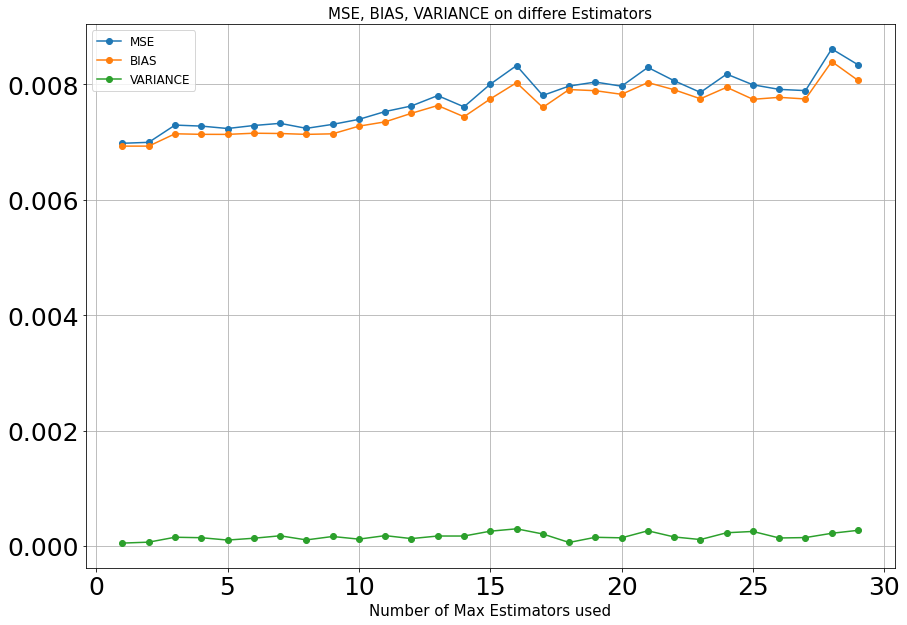

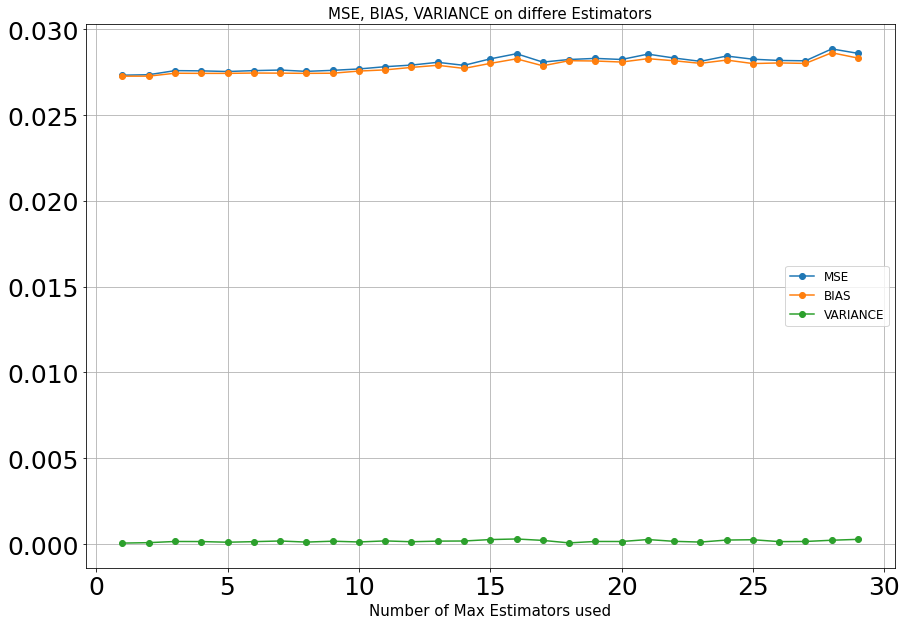

In [22]:
boost_model.append(
    get_bmodel(0)
)

TUNING DEL NUMERO DI STIMATORI TRAIN

Punteggio finale: 0.008402517678626698 (30) stimatori
Best mse:, 0.00762906788765798
Best number of Estimators: 2

Punteggio finale: 0.007940941058113968 (30) stimatori
Best bias:, 0.007536243133948986
Best number of Estimators: 2

Punteggio finale: 0.0004615766205127335 (30) stimatori
Best var:, 9.282475370898596e-05
Best number of Estimators: 2

TUNING DEL NUMERO DI STIMATORI VALIDATION

Punteggio finale: 0.02037516086819978 (30) stimatori
Best mse:, 0.019683593205887615
Best number of Estimators: 1

Punteggio finale: 0.01991195041661577 (30) stimatori
Best bias:, 0.019604290373871732
Best number of Estimators: 1

Punteggio finale: 0.0004632104515840113 (30) stimatori
Best var:, 7.930283201588188e-05
Best number of Estimators: 1



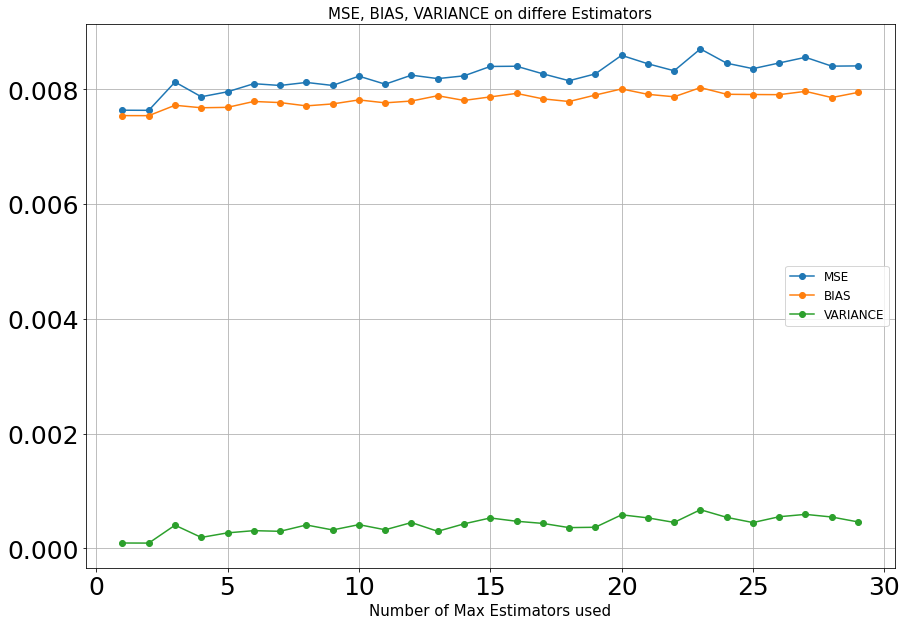

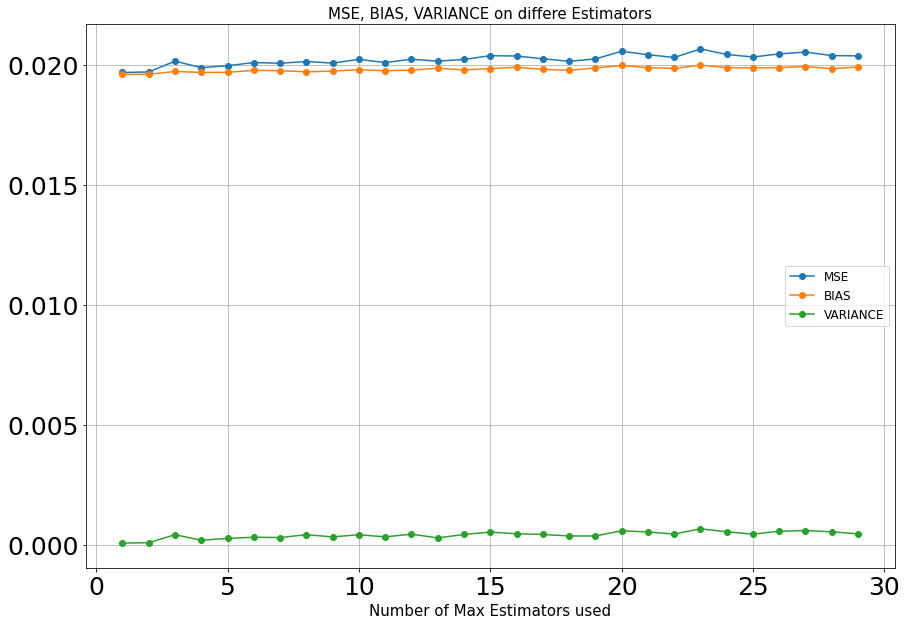

In [23]:
boost_model.append(
    get_bmodel(1)
)

TUNING DEL NUMERO DI STIMATORI TRAIN

Punteggio finale: 0.011963551722169142 (30) stimatori
Best mse:, 0.011436625982950619
Best number of Estimators: 2

Punteggio finale: 0.011806385571282088 (30) stimatori
Best bias:, 0.011376801972796943
Best number of Estimators: 1

Punteggio finale: 0.00015716615088710032 (30) stimatori
Best var:, 5.9695870412382825e-05
Best number of Estimators: 2

TUNING DEL NUMERO DI STIMATORI VALIDATION

Punteggio finale: 0.025564168916640196 (30) stimatori
Best mse:, 0.02499017567374099
Best number of Estimators: 2

Punteggio finale: 0.02540658204048703 (30) stimatori
Best bias:, 0.02493713872629054
Best number of Estimators: 2

Punteggio finale: 0.00015758687615313258 (30) stimatori
Best var:, 5.3036947450346814e-05
Best number of Estimators: 2



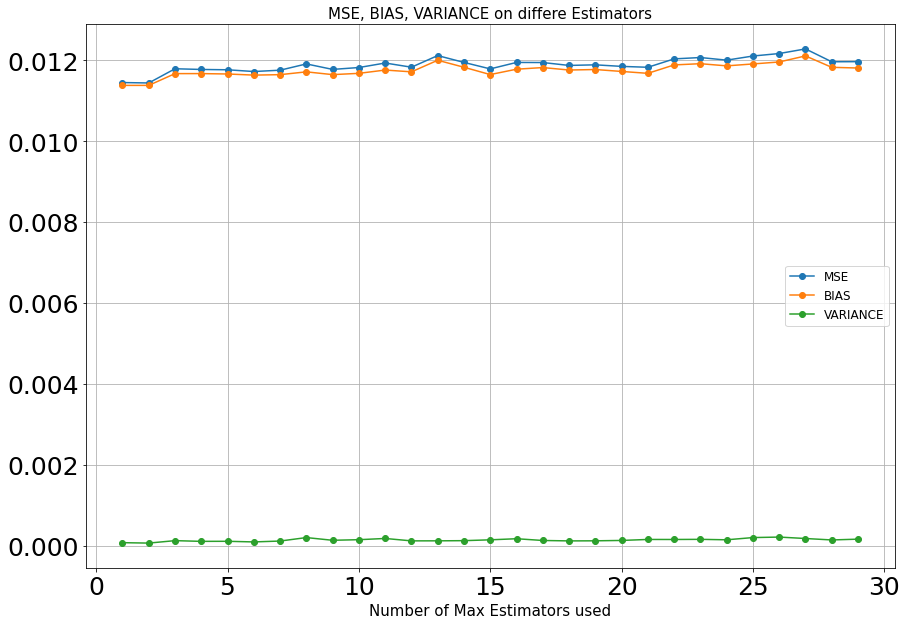

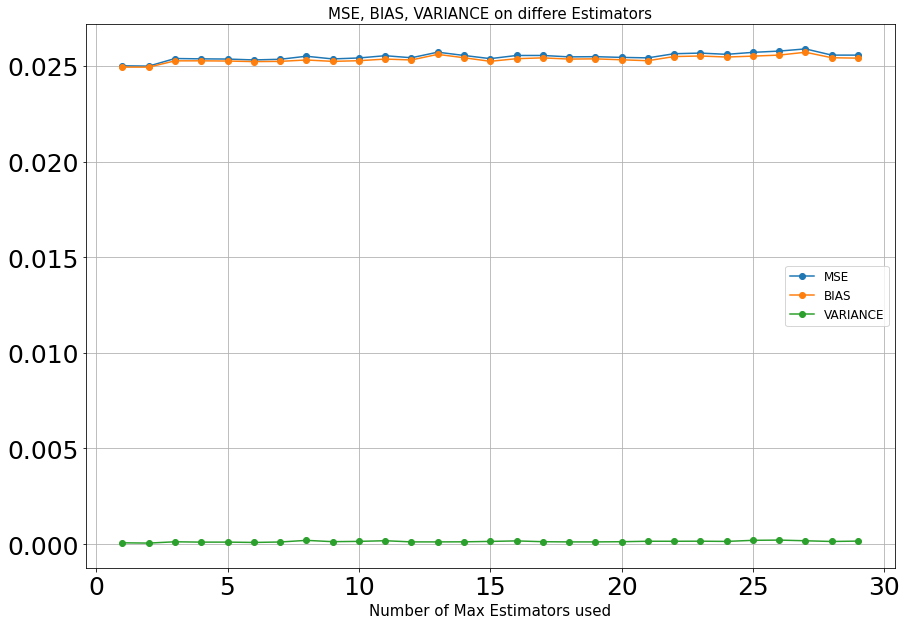

In [24]:
boost_model.append(
    # get_bmodel(2)
    boosting_train(
        X_train [2][:25000],\
        y_train [2][:25000],\
        X_val   [2],\
        y_val   [2],\
        dt_model[2],\
        verbose = False,\
        debug   = False
    )
)

In [25]:
boost_model

[AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=2),
                   n_estimators=1),
 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=2),
                   n_estimators=1),
 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=2),
                   n_estimators=1)]

In [27]:
# Train
for i in range(3):
    print(region_names[i])
    print(get_score(boost_model[i], X_train[i], y_train[i]))
    print()

A
{'mse': 0.006903841101032464, 'score': 0.0036832036867041618}

B
{'mse': 0.00751907530859129, 'score': 0.0019902432091887245}

C
{'mse': 0.011190683570572141, 'score': 0.0015793865840409982}



In [28]:
# Validation
for i in range(3):
    print(region_names[i])
    print(get_score(boost_model[i], X_val[i], y_val[i]))
    print()

A
{'mse': 0.02729212686945306, 'score': -0.0010038733229971175}

B
{'mse': 0.019781611447508427, 'score': -0.00951626922646942}

C
{'mse': 0.024935032575760883, 'score': -1.5610684870992486e-05}



In [29]:
# Test
for i in range(3):
    print(region_names[i])
    print(get_score(boost_model[i], X_val[i], y_val[i]))
    print()

A
{'mse': 0.02729212686945306, 'score': -0.0010038733229971175}

B
{'mse': 0.019781611447508427, 'score': -0.00951626922646942}

C
{'mse': 0.024935032575760883, 'score': -1.5610684870992486e-05}

